In [1]:
import tensorflow.keras as keras
from keras.models import load_model
import os

import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency, visualize_saliency_with_losses, visualize_activation
from vis.utils import utils
from keras import activations
import matplotlib.image as mpimg
import scipy.ndimage as ndimage

from pandas import read_csv
from numpy import dstack
from keras.utils import to_categorical

from scipy import signal
from scipy import stats
import math
import time
import pickle
import numpy as np

#os.mkdir('tmp')

Using TensorFlow backend.


In [2]:
from keras.models import load_model
#saved_model= load_model('CascadeModel_S8_C1to7_Epochs50.h5')#layer = 'dense_6'
saved_model= load_model('EEG_AllDataset/CascadeModel_S8_C1to7_Epochs50.h5')#layer = 'dense_6'
opt = keras.optimizers.Adam(learning_rate=1e-4)
saved_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
saved_model.summary()
#layer = 'time_distributed_9'
layer = 'dense_6'
#layer = 'dense_3'

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 8, 9, 9, 32)       320       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 8, 9, 9, 64)       18496     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 8, 9, 9, 128)      73856     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 8, 10368)          0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 8, 1024)           10617856  
_________________________________________________________________
time_distributed_12 (TimeDis (None, 8, 1024)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 8)             

C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
# load the training/testing data
with open("EEG_AllDataset/CascadeModel_trainData.pickle", "rb") as f:
    Dataset = pickle.load(f)
    
#X_train = Dataset[0]
X_test = Dataset[1]
#y_train = Dataset[2]
y_test = Dataset[3]
Dataset = None

# get predictions from the model for the testing data
predictions = saved_model.predict(X_test,batch_size=64, verbose=1)


66062/66062 [==============================] - 146s 2ms/step


In [4]:
inputs_fname = "inputs_S8_C1to7.h5"
targets_db_fname = "targets_S8_C1to7.h5"
wins_db_fname = "wins_S8_C1to7.h5"
db_fname = "NoArt_ME_db_128.pickle"

def loadData(fname):
    db_dir = "C:/Users/Liangyu/Desktop/BME725/Final Project/eeg-deeplearning/Test_CNN_LSTM_Saliency/EEG_456Dataset"
    fs = 128
    db = []
    t1 = time.time()
    with open(db_dir + "/" + fname, "rb") as f:
        db = pickle.load(f)
    print("Loaded ME database in %f s" % (time.time()-t1))
    return db

inputs = loadData(inputs_fname)
targets = loadData(targets_db_fname)
wins = loadData(wins_db_fname)
db = loadData(db_fname)


where_are_NaNs = np.isnan(inputs)
inputs[where_are_NaNs] = 0
targets = targets-1

Loaded ME database in 3.674180 s
Loaded ME database in 0.005985 s
Loaded ME database in 0.006982 s
Loaded ME database in 1.376323 s


In [5]:
print(inputs[targets==0].shape)
print(inputs[targets==1].shape)
print(np.mean(inputs[targets==1],axis=0).shape)

(47187, 8, 9, 9)
(47187, 8, 9, 9)
(8, 9, 9)


In [7]:
predictionsCorr = predictions[predictions.argmax(axis=1)==y_test-1,:]
out_arr = np.argsort(np.max(predictionsCorr, axis=1)) 

X_testCorr = X_test[predictions.argmax(axis=1)==y_test-1,:]
X_testCorr = X_testCorr[out_arr,:,:,:]
predictionsCorr = predictionsCorr.argmax(axis=1)[out_arr]

# take the most accurate and activated for each class
bestClass = {}
for i in np.unique(predictionsCorr):
    occurences = np.where(predictionsCorr == i)
    mostConfident = occurences[0][-10:]
    highestActivation = np.argmax(np.sum(np.absolute(X_testCorr[mostConfident]),axis=(1,2,3,4)))
    bestClass[i] = X_testCorr[mostConfident[highestActivation]]

#predictions2 = predictions[predictions.argmax(axis=1)==y_test-1,:]
#print((np.shape(predictions2)[0])/(np.shape(predictions)[0]))
#print(np.shape(predictions2))
#np.max(predictions2, axis=1).shape
#plt.plot(np.sort(np.max(predictions2, axis=1)))

[-59.73645212516982, 184.99118046246667]

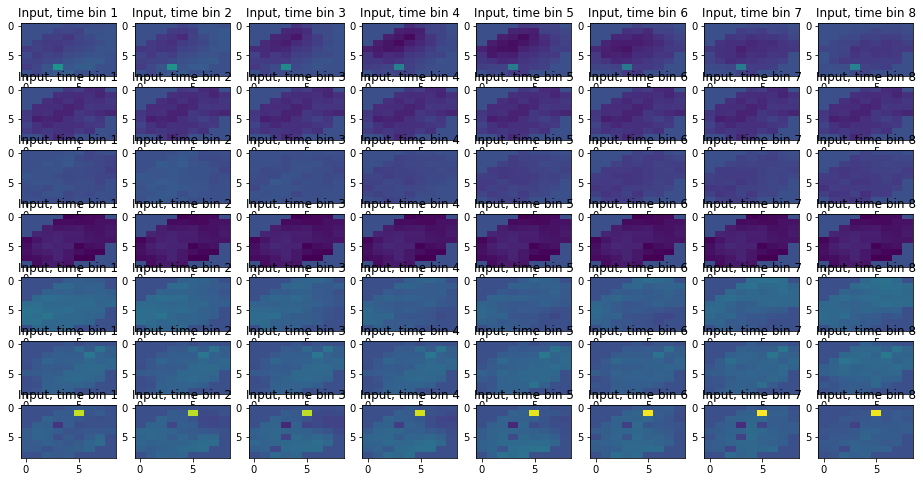

In [10]:
# take the average for each class
classes = np.unique(targets)
nTrialPerClas = targets.shape[0]/len(classes)

meanClas = {}
for clas in classes:
    meanClas[clas] = np.mean(inputs[targets==clas],axis=0)
        
# normalize the colorbars for all of the time bins to the same range
vminInput=0
vmaxInput=0
for clas in classes:
    if vminInput>bestClass[clas].min():
        vminInput = bestClass[clas].min()
    if vmaxInput<bestClass[clas].max():
        vmaxInput = bestClass[clas].max()

display([vminInput, vmaxInput])

# plot the sample trial
fig, (axs) = plt.subplots(7, 8, figsize = (16,8))
c = 0
for clas in classes:
    for t in range(0,8):
        axs[c, t].imshow(bestClass[clas][t][:,:,0], aspect='auto', vmin=vminInput, vmax=vmaxInput)#meanClas
        axs[c, t].set_title('Input, time bin '+str(t+1))
    #axs[1, 0].set_xlabel('Features')
    #axs[1, 0].set_ylabel('time in bin')
    c = c+1


In [31]:
def computSaliency(saved_model, seed_input, layer='dense_281'):
    # choose the layer that whose output you want to set as dy
    layer_idx = utils.find_layer_idx(saved_model, layer)
    # change the activation function of that layer to linear
    saved_model.layers[layer_idx].activation = activations.linear
    model = utils.apply_modifications(saved_model)

    # compute saliency map
    grads = visualize_saliency(model, layer_idx, filter_indices=None, \
                               seed_input=seed_input, backprop_modifier=None, \
                               grad_modifier = "absolute", keepdims=True)
    return grads

def computActivation(saved_model, seed_input, layer='dense_281'):
    # choose the layer that whose output you want to set as dy
    layer_idx = utils.find_layer_idx(saved_model, layer)
    # change the activation function of that layer to linear
    saved_model.layers[layer_idx].activation = activations.linear
    model = utils.apply_modifications(saved_model)

    # compute saliency map
    maps = visualize_activation(model, layer_idx, filter_indices=None, \
                                input_range=(seed_input.min(), seed_input.max()))
    return maps




def plotSaliency(seed_input, grads,plotFig=False,fName="saliency.pdf"):
    vminInput=seed_input.min()
    vmaxInput=seed_input.max()
    vminSaliency=0#grads.min()
    vmaxSaliency=1#grads.max()

    fig, axs = plt.subplots(2, 8, figsize = (16,8))
    for i in range(0,8):
        p1 = axs[0, i].imshow(seed_input[i], aspect='auto', vmin=vminInput, vmax=vmaxInput);
        axs[0, i].set_title('Input, bin '+str(i+1))
        p2 = axs[1, i].imshow(grads[i,:,:], aspect='auto', vmin=vminSaliency, vmax=vmaxSaliency);#grads[i]
        axs[1, i].set_title('Saliency, bin '+str(i+1))
        if i == 0:
            axs[1, i].set_xlabel('x')
            axs[1, i].set_ylabel('y')
        if i==7:
            cb1 = plt.colorbar(p1, ax=axs[0, i])
            cb2 = plt.colorbar(p2, ax=axs[1, i], panchor=False)
    if plotFig:
        fig.savefig(fName, bbox_inches='tight')
    return cb1, cb2

def getInfluentialChannels(grads, mesh, quart=99):
    #thresh = np.percentile(np.sort(grads.flatten()), quart)
    thresh = 0.85
    chanLoc = np.zeros((1,3),dtype=int)
    for t in range(0,8):
        for i in range(0,9):
            for j in range(0,9):
                if grads[t,i,j]>thresh:
                    #chanLoc = np.append([chanLoc, [t,i,j]],axis=0)
                    chanLoc = np.append(chanLoc, [[t,i,j]], axis=0)
    chanLoc = np.delete(chanLoc, 0, 0)

    a = []
    for chan in range(0,chanLoc.shape[0]):
        x = chanLoc[chan][1]
        y = chanLoc[chan][2]
        a.append(mesh[x][y])

    b = set(a)
    try:
        b.remove('')
    except:
        b
    return b

In [26]:
grads[:,:,:,0].shape

(8, 9, 9)

C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


0

C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1

C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


2

C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


3

C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


4

C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


5

C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


6

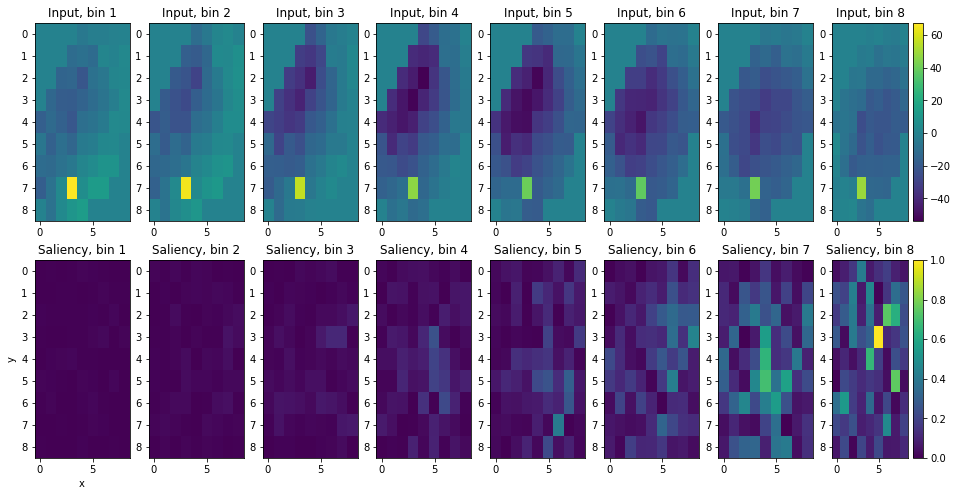

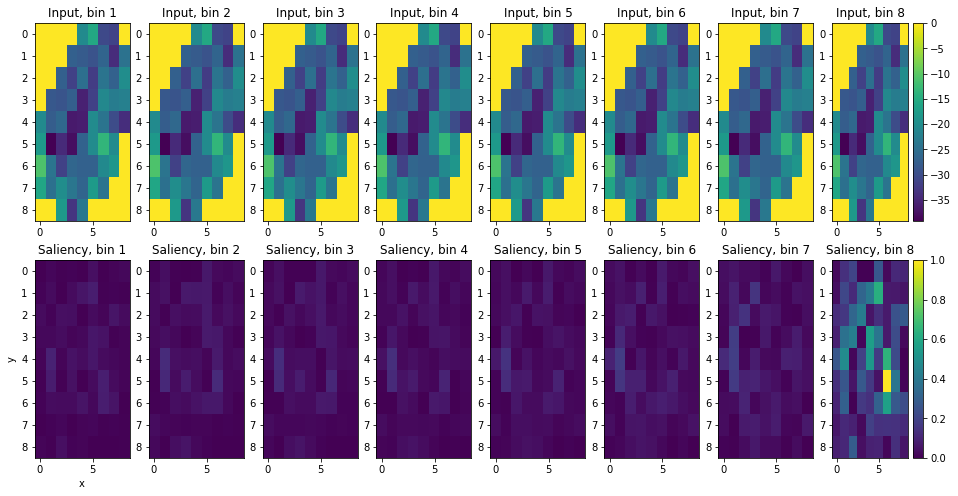

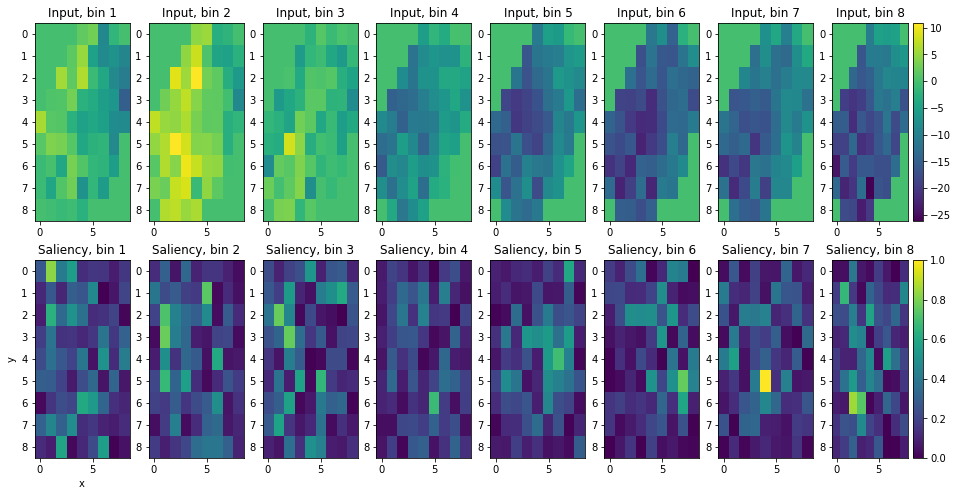

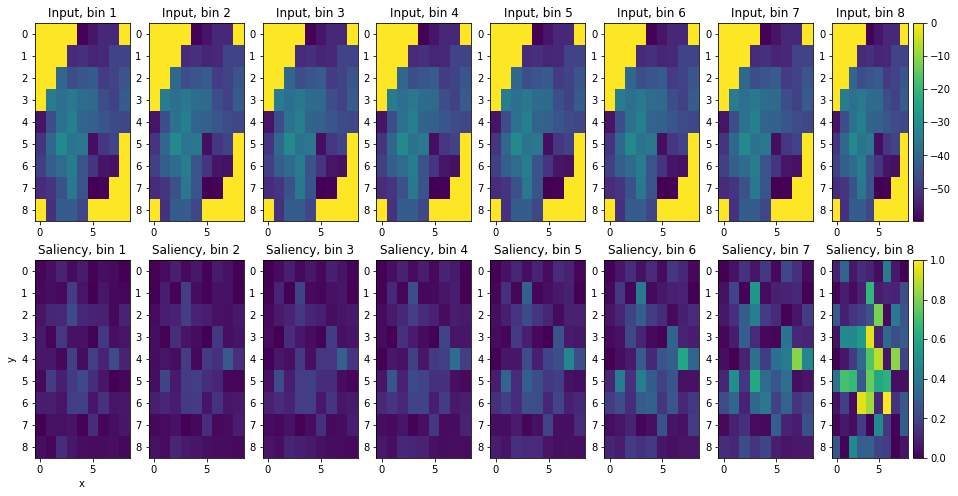

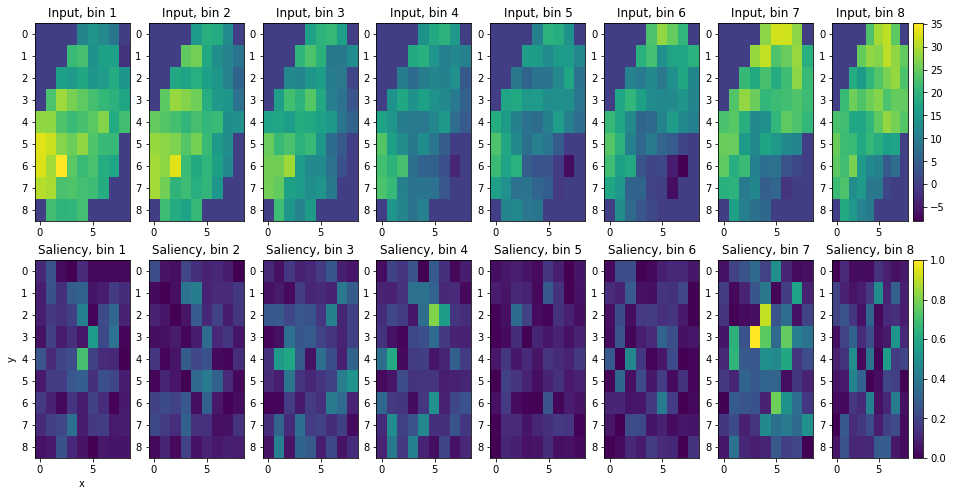

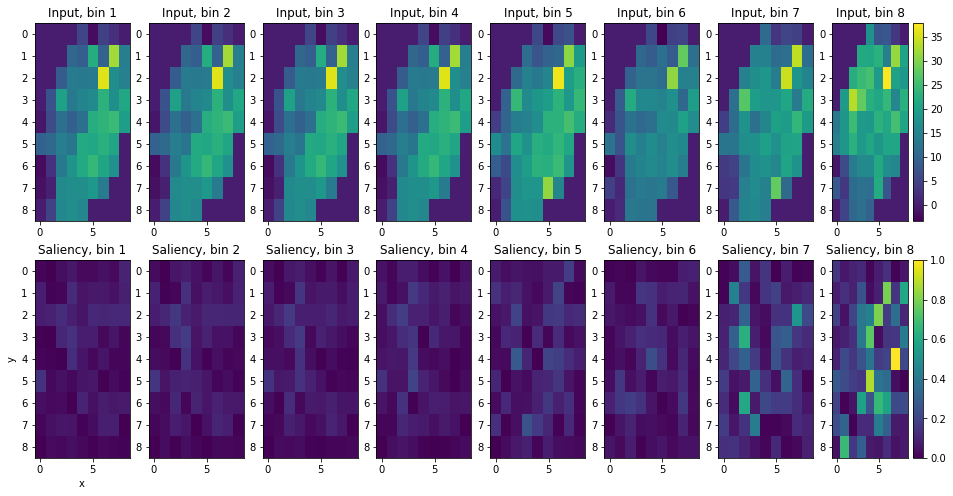

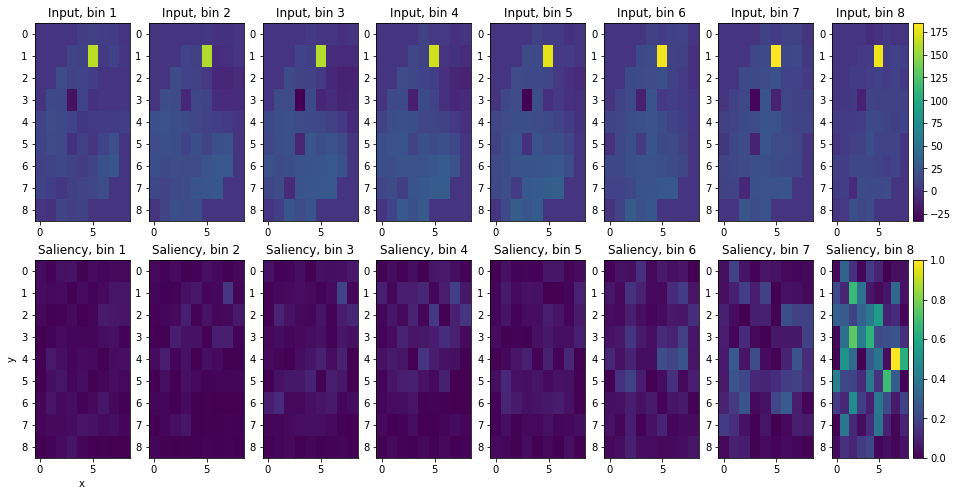

In [32]:
from channel_maps import channel_label_map, channel_loc_map

CLM = channel_loc_map()
# populate the mesh with the electrodes
mesh = [ [ "" for y in range(0,9) ] for x in range(0,9) ] 
for chan in range(0,np.shape(CLM)[0]):
    mesh[CLM[chan][0]][CLM[chan][1]] = channel_label_map[chan+1]

ch = {}
for clas in classes:
    seed_input = bestClass[clas]#meanClass
    grads = computSaliency(saved_model, seed_input, layer=layer)
    fName="saliency_C"+str(clas)+"_max.pdf"
    plotSaliency(seed_input[:,:,:,0], grads[:,:,:,0], plotFig=True,fName=fName)
    
    ch[clas] = getInfluentialChannels(grads[:,:,:,0], mesh, quart=99.5)
    display(clas)

In [34]:
display(ch)

{0: {'C2'},
 1: {'CPP2h'},
 2: {'C3', 'CCP1h'},
 3: {'CCP2h', 'CCP3h', 'CP1', 'FCC2h', 'Pz'},
 4: {'FC2', 'FCz'},
 5: {'CCP1h', 'CPP4h'},
 6: {'CPP4h'}}

In [40]:
def plotMRCP(ME_db_norm, classes=[1,2,3], ch=[14, 27, 30, 31], claslabels=['1','2','3'], plotFig=False, fName1="MRCP.pdf", fName2="MRCP_std.pdf"):
    nChan = len(ch)
    nPt = np.shape(db[1])[1]
    nClas = len(db)
    nTrial = np.shape(db[1])[0]
    fs = 128
    xRange = (np.arange(nPt)-(nPt-1)/2)/fs

    mean = np.zeros((nChan,nClas,nPt))
    sem = np.zeros((nChan,nClas,nPt))
    for c in range(0, nChan):
        for i in range(0,nClas):
            tmpDat = db[i+1][:,:,c]
            mean[c,i] = np.mean(tmpDat,axis=0)
            sem[c,i] = stats.sem(tmpDat,axis=0)
    
    fig, (axs) = plt.subplots(4, 3, figsize = (20,20))
    for c in range(0, nChan):
        x = math.floor(c/4)
        y = c%4
        for i in classes:
            axs[y, x].fill_between(xRange, mean[c,i,:]-sem[c,i,:], mean[c,i,:]+sem[c,i,:], alpha = 0.5)
            axs[y, x].plot(xRange,mean[c,i,:],label=claslabels[i])
        axs[y, x].set_xlim([xRange.min(),xRange.max()])
        axs[y, x].set_title(channel_label_map[ch[c]+1])
        if c==0 & i==classes[0]:
            axs[y, x].legend()
        
        
        if x == 0:
            axs[y, x].set_ylabel('uV')
        if y == 4:
            axs[y, x].set_xlabel('time (s)')
    axs[y, x].legend()
    if plotFig:
        fig.savefig(fName1, bbox_inches='tight')

In [38]:
channel_label_map
allCh = []
for clas in classes:
    allCh = np.append(allCh, list(ch[clas]))
allCh = set(allCh)

values = []
for i in range(1,65):
    values.append(channel_label_map[i])
    
display(allCh)
display(np.transpose(values))

ch2Plot = [i for i, e in enumerate(values) if e in set(allCh)]
print(ch2Plot)

{'C2',
 'C3',
 'CCP1h',
 'CCP2h',
 'CCP3h',
 'CP1',
 'CPP2h',
 'CPP4h',
 'FC2',
 'FCC2h',
 'FCz',
 'Pz'}

array(['F3', 'F1', 'Fz', 'F2', 'F4', 'FFC5h', 'FFC3h', 'FFC1h', 'FFC2h',
       'FFC4h', 'FFC6h', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6',
       'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h',
       'FTT8h', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'TTP7h',
       'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h',
       'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'CPP5h', 'CPP3h',
       'CPP1h', 'CPP2h', 'CPP4h', 'CPP6h', 'P3', 'P1', 'Pz', 'P2', 'P4',
       'PPO1h', 'PPO2h', 'EOG left', 'EOG middle', 'EOG right'],
      dtype='<U10')

[14, 15, 22, 27, 30, 35, 36, 37, 43, 51, 52, 56]


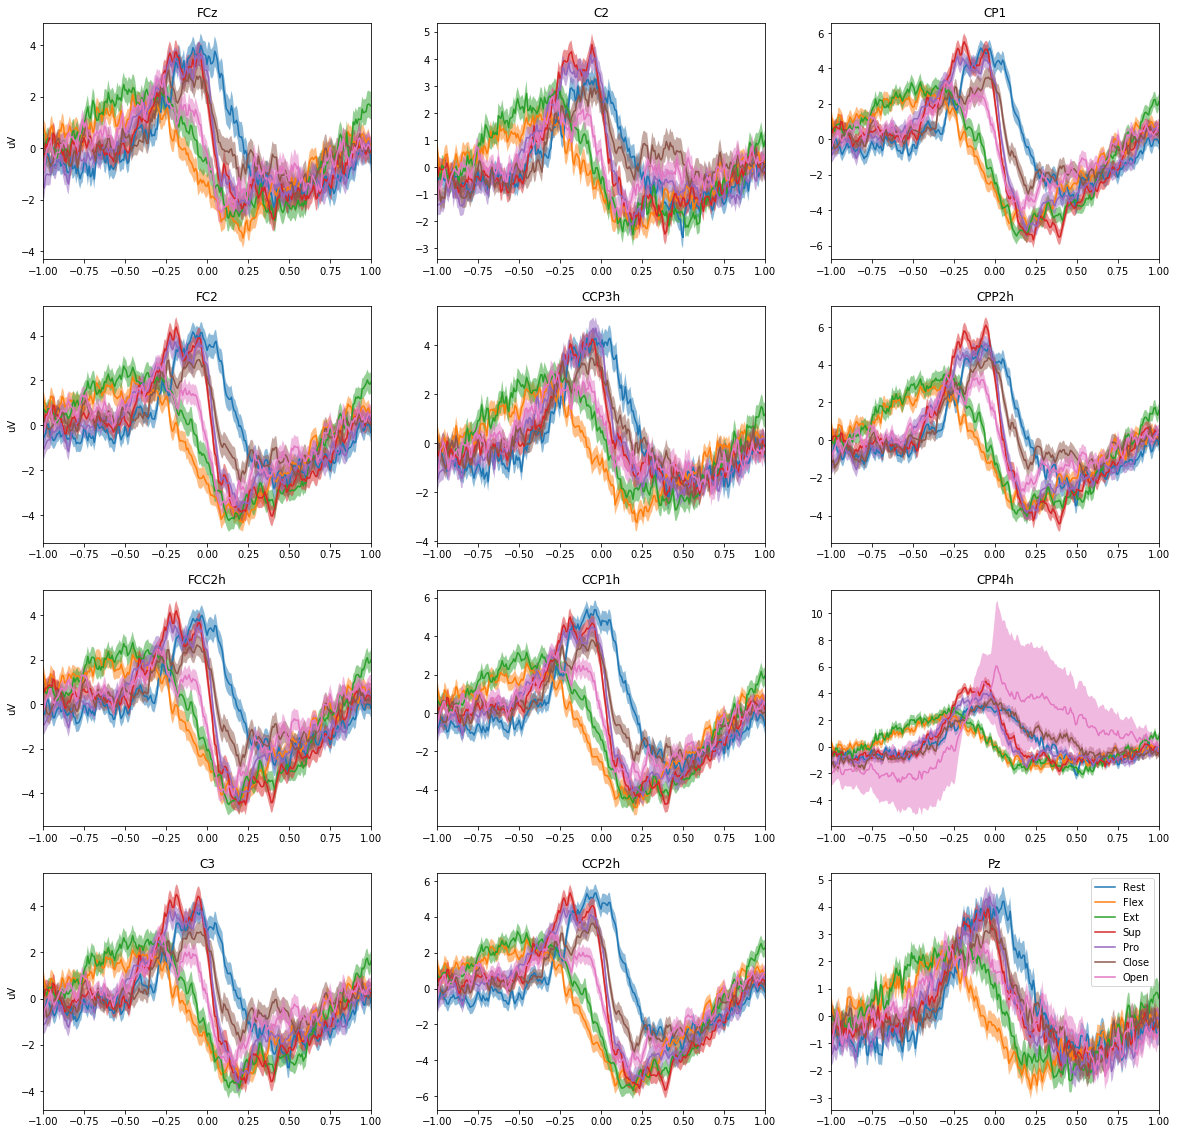

In [41]:
fName="MRCP_max.pdf"
claslabels = ['Flex','Ext','Sup','Pro','Close','Open','Rest']
plotMRCP(db, classes-1, ch2Plot, claslabels, plotFig=True,fName1=fName)
#plotMRCP(db, [0,1,2,6], ch2Plot, claslabels)